<a href="https://colab.research.google.com/github/pravinkr/GAN-Keras/blob/master/cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division


import tensorflow as tf

from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D,  Dropout, Flatten, Dense, Input, Reshape
from keras.layers import Activation, Conv2DTranspose, UpSampling2D, BatchNormalization, Embedding, multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist, fashion_mnist
from keras.optimizers import Adam, RMSprop
from PIL import Image
from tqdm import tqdm
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

class CGAN:

	def __init__(self, rows=28, cols=28, channels=1):
		self.rows = rows
		self.cols = cols
		self.channels = channels
		self.shape = (self.rows, self.cols, self.channels)
		self.latent_size = 100
		self.sample_rows = 2
		self.sample_cols = 5
		self.sample_path = 'images'
		self.num_classes = 10

		optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
		
		
		image_shape = self.shape
		seed_size = self.latent_size
		
		
		#Get the discriminator and generator Models
		print("Build Discriminator")
		self.discriminator = self.build_discriminator()
		
		self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  
		print("Build Generator")
		
		self.generator = self.build_generator()
		
		random_input = Input(shape=(seed_size,))
		label = Input(shape=(1,))
		
		#Pass noise/random_input and label as input to the generator
		generated_image = self.generator([random_input,label])
		
		#Put discriminator.trainable to False. We do not want to train the discriminator at this point in time
		self.discriminator.trainable = False
		
		#Pass generated image and label as input to the discriminator
		validity = self.discriminator([generated_image,label])
		
		#Pass radom input and label as input to the combined model
		self.combined_model = Model([random_input,label], validity)
		self.combined_model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
		
	def build_discriminator(self):
	
		input_shape = self.shape
		model = Sequential()
		model.add(Conv2D(64, (3,3), strides=2, padding='same', input_shape=input_shape))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.4))
		
		model.add(Conv2D(128,(3,3), strides=2, padding='same'))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.4))
		
		model.add(Conv2D(256, (3,3), strides=2, padding='same'))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.4))
		
		model.add(Conv2D(512, (3,3), padding='same'))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.4))
		
		model.add(Flatten())
		
		model.add(Dense(1,activation='sigmoid'))
		

		input_image = Input(shape=input_shape)
		label = Input(shape=(1,))
		
		label_embeddings = Flatten()(Embedding(self.num_classes, np.prod(self.shape))(label))
		flat_image = Flatten()(input_image)
		
		
		model_input = multiply([flat_image, label_embeddings])
		model_input = Reshape((28,28,1))(model_input)
	
		
		validity = model(model_input)
		
		return Model([input_image,label],validity)	

	def build_generator(self):
	
	
		seed_size = self.latent_size
		model = Sequential()
		model.add(Dense(7*7*256, input_dim=seed_size))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		
		model.add(Reshape((7,7,256)))
		model.add(Dropout(0.4))
		
		model.add(Conv2DTranspose(128,(5,5),padding='same'))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		model.add(UpSampling2D())
		
		model.add(Conv2DTranspose(64,(3,3),padding='same'))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		model.add(UpSampling2D())
		
		model.add(Conv2DTranspose(32,(3,3),padding='same'))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		
		model.add(Conv2DTranspose(1,(3,3),padding='same'))
		model.add(Activation('sigmoid'))
		
		noise = Input(shape=(seed_size,))
		label = Input(shape = (1,), dtype='int32')
		
		label_embeddings = Flatten()(Embedding(self.num_classes,self.latent_size)(label))
		
		
		input = multiply([noise,label_embeddings])
		
		generated_image = model(input)
		
	
		return(Model([noise,label],generated_image))

		

	def plot_sample_images(self, epoch, noise):
		r, c = self.sample_rows, self.sample_cols
		
		sampled_labels = np.arange(0, self.num_classes).reshape(-1, 1)
	
		gen_imgs = self.generator.predict([noise,sampled_labels])
		
		filename = os.path.join(self.sample_path,'%d.png'% epoch)
		fig, axs = plt.subplots(r, c)
		cnt = 0
		for i in range(r):
			for j in range(c):
				axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
				axs[i,j].axis('off')
				cnt += 1
		fig.savefig(filename)
		plt.close()


	def plot_loss(self,losses):
		"""
		@losses.keys():
			0: loss
			1: accuracy
		"""
		d_loss = [v[0] for v in losses["D"]]
		g_loss = [v[0] for v in losses["G"]]
		
		plt.figure(figsize=(10,8))
		plt.plot(d_loss, label="Discriminator loss")
		plt.plot(g_loss, label="Generator loss")
		
		plt.xlabel('Epochs')
		plt.ylabel('Loss')
		plt.legend()
		plt.show()

		
	def train(self, epochs=10000, batch_size=32, save_freq=200):
   
		seed_size = self.latent_size
		
    #Load Dataset
		#(x_train,y_train),(_,_) = mnist.load_data()
		(x_train,y_train),(_,_) = fashion_mnist.load_data()
		
		#normalize and reset train set in range (0,1) # normalizing to (-1,1) seems to be not working.
		
		x_train = np.expand_dims(x_train, axis=-1)
		y_train = y_train.reshape(-1,1)

		#x_train = (x_train.astype('float32') / 127.5 ) - 1. # Normalizing this way doesn't work during training.
		
		x_train = x_train.astype('float32')/255.0 #Normalizing  this way does work during training.
		
  
		print("x_train.shape",x_train.shape)

		#Ground Truth. Setting real images labels to True
		y_real = np.ones((batch_size,1))

		#Setting fake images labels to False
		y_fake = np.zeros((batch_size,1))
		
    
		#fixed_seed = np.random.normal(0,1,size=[25,seed_size])
		
		cnt = 1
		
		#Generating Fixed noise to be passed for sampling with same inputs after set of epochs and seeing the results
		noise_input = np.random.normal(0,1,size=[self.sample_rows*self.sample_cols,seed_size])
		
		#Setup loss vector to store losses for Generator and Discriminator
		
		losses = {"D":[], "G":[]}

		path = self.sample_path
		if not os.path.isdir(path):
		  os.mkdir(path)

		for epoch in range(epochs):


      #Training of Discriminator. Taking random samples of batch_size #
			noise = np.random.normal(0,1,size=[batch_size,seed_size])
			
      #take random batched of indexes for x_train
			idx = np.random.randint(0,x_train.shape[0],size=batch_size)
			
			x_real, y_real = x_train[idx], y_train[idx]
			
			
			#Generate some fake images
			#print("generator.predit")
			x_fake = self.generator.predict([noise,y_real])
			#print("generator.predit done")

			x = np.concatenate((x_real,x_fake))
			concat_labels = np.concatenate((y_real, y_real))
			
			y = np.ones([2*batch_size,1])
			y[batch_size:,:] = 0
			
			#Train discriminator on real and fake
			d_loss = self.discriminator.train_on_batch([x,concat_labels],y)
	 
			#Train Generator on Calculated loss
			y = np.ones([batch_size, 1])

			#noise = np.random.uniform(-1.0, 1.0, size=[batch_size, SEED_SIZE])
			noise = np.random.normal(0,1,size=[batch_size,seed_size])
			sampled_labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)
			
			g_loss = self.combined_model.train_on_batch([noise,sampled_labels],y)
			
			losses["D"].append(d_loss)
			losses["G"].append(g_loss)
			
			#Time for an update
			
			if save_freq > 0:
				if epoch % save_freq == 0:
			
					print ("epoch %d: [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], 100*g_loss[1]))
					self.plot_sample_images(epoch, noise_input)
					cnt+=1

		self.plot_loss(losses)
		


Build Discriminator
Build Generator
4423680/4422102 [==============================] - 1s 0us/step
x_train.shape (60000, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch 0: [D loss: 0.693119, acc.: 54.69%] [G loss: 0.696970, acc.: 6.25%]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch 200: [D loss: 0.701584, acc.: 40.62%] [G loss: 0.701804, acc.: 46.88%]
epoch 400: [D loss: 0.689616, acc.: 51.56%] [G loss: 0.706656, acc.: 46.88%]
epoch 600: [D loss: 0.691072, acc.: 57.81%] [G loss: 0.679907, acc.: 75.00%]
epoch 800: [D loss: 0.693551, acc.: 45.31%] [G loss: 0.684830, acc.: 62.50%]
epoch 1000: [D loss: 0.689256, acc.: 51.56%] [G loss: 0.715214, acc.: 34.38%]
epoch 1200: [D loss: 0.693612, acc.: 45.31%] [G loss: 0.701208, acc.: 46.88%]
epoch 1400: [D loss: 0.682727, acc.: 62.50%] [G loss: 0.680737, acc.: 59.38%]
epoch 1600: [D loss: 0.699615, acc.: 40.62%] [G loss: 0.715369, acc.: 37.50%]
epoch 1800: [D loss: 0.695145, acc.: 53.12%] [G loss: 0.686956, acc.: 62.50%]
epoch 2000: [D loss: 0.691648, acc.: 48.44%] [G loss: 0.702620, acc.: 50.00%]
epoch 2200: [D loss: 0.705293, acc.: 51.56%] [G loss: 0.565976, acc.: 100.00%]
epoch 2400: [D loss: 0.699836, acc.: 57.81%] [G loss: 0.617335, acc.: 96.88%]
epoch 2600: [D loss: 0.638591, acc.: 65.62%] [G loss: 0.705289, acc

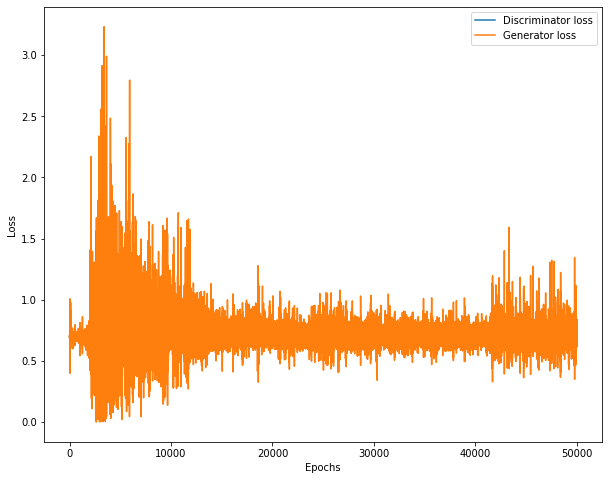

In [0]:
gan = CGAN()

gan.train(epochs=50000)